
# Probability Calibration for 3-class classification

This example demonstrates the effect of sigmoid `calibration <calibration>` on predicted probabilities in a 3-class classification problem. The standard 2-simplex is shown, with its three corners representing the three classes. Arrows indicate the shift from the probability vectors predicted by an uncalibrated classifier to those predicted by the same classifier after sigmoid calibration using a hold-out validation set. The true class of an instance is indicated by its color: red for class 1, green for class 2, and blue for class 3.

## Data
In the following example, we create a classification dataset with 3 target classes, 2 features and 2000 samples. The data is then divided as follows:

* train: 600 samples (for training the classifier)
* valid: 400 samples (for calibrating predicted probabilities)
* test: 1000 samples

It is important to note that we also generate `X_train_valid` and `y_train_valid`, which include both the train and valid subsets. These are used when the goal is to train the classifier without calibrating the predicted probabilities.

In [1]:
# Author: Zakariyae CHATRI <zakariyae.chatri@usmba.ac.ma>

import numpy as np
from sklearn.datasets import make_blobs

np.random.seed(0)

X, y = make_blobs(
    n_samples=2000, n_features=2, centers=3, random_state=42, cluster_std=5.0
)
X_train = X[:600]
y_train = y[:600]
X_valid = X[600:1000]
y_valid = y[600:1000]
X_train_valid = X[:1000]
y_train_valid = y[:1000]
X_test = X[1000:]
y_test = y[1000:]

## Fitting and calibration

Initially, we will train an uncalibrated :class:`~sklearn.ensemble.RandomForestClassifier` with 25 base estimators (trees) using the combined train and validation data (1000 samples).


In [2]:
from sklearn.ensemble import RandomForestClassifier as RFC

clf = RFC(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)

RandomForestClassifier(n_estimators=25)

To train the calibrated classifier, we begin with the same :class:`~sklearn.ensemble.RandomForestClassifier`, but only train it on the train data subset (600 samples). Then, we calibrate it using the valid data subset (400 samples) in a 2-stage process with `method='sigmoid'`.


In [3]:
from sklearn.calibration import CalibratedClassifierCV as CCCV

clf = RFC(n_estimators=25)
clf.fit(X_train, y_train)
cal_clf = CCCV(clf, method="sigmoid", cv="prefit")
cal_clf.fit(X_valid, y_valid)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(n_estimators=25))

## Compare probabilities
In the following diagram, we plot a 2-simplex with arrows indicating the shift in predicted probabilities for the test samples.



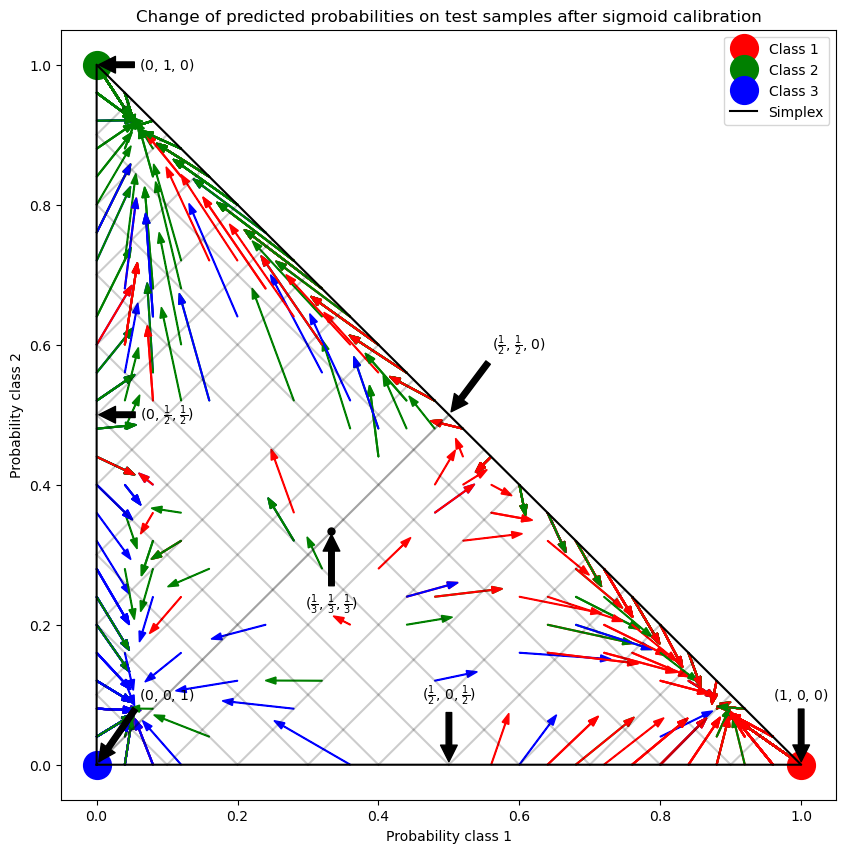

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
colors = ["r", "g", "b"]

clf_probs = clf.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)
# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color=colors[y_test[i]],
        head_width=1e-2,
    )

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], "ro", ms=20, label="Class 1")
plt.plot([0.0], [1.0], "go", ms=20, label="Class 2")
plt.plot([0.0], [0.0], "bo", ms=20, label="Class 3")

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(
    r"($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)",
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.plot([1.0 / 3], [1.0 / 3], "ko", ms=5)
plt.annotate(
    r"($\frac{1}{2}$, $0$, $\frac{1}{2}$)",
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $\frac{1}{2}$, $\frac{1}{2}$)",
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($\frac{1}{2}$, $\frac{1}{2}$, $0$)",
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $0$, $1$)",
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($1$, $0$, $0$)",
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $1$, $0$)",
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Change of predicted probabilities on test samples after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

In the above figure, each vertex of the simplex represents a perfectly predicted class (e.g., 1, 0, 0), while the midpoint inside the simplex represents equal probability prediction for all three classes (i.e., 1/3, 1/3, 1/3). Each arrow originates from the uncalibrated probabilities and ends at the calibrated probability, with the arrow color indicating the true class of that test sample.

The uncalibrated classifier is overly confident in its predictions and incurs a large `log loss <log_loss>`. However, the calibrated classifier incurs a lower `log loss <log_loss>` due to two reasons. Firstly, as seen in the figure above, the arrows generally point away from the edges of the simplex where one class has a probability of 0. Secondly, a significant proportion of arrows point towards the true class. For example, green arrows (samples where the true class is 'green') generally point towards the green vertex. This results in fewer over-confident predictions with a probability of 0 and an increase in predicted probabilities for the correct class. Thus, the calibrated classifier produces more accurate predicted probabilities with a lower `log loss <log_loss>`.

This can be objectively demonstrated by comparing the `log loss <log_loss>` of the uncalibrated and calibrated classifiers on the predictions of 1000 test samples. An alternative approach would have been to increase the number of base estimators (trees) in the :class:`~sklearn.ensemble.RandomForestClassifier`, resulting in a similar decrease in `log loss <log_loss>`.

In [5]:
from sklearn.metrics import log_loss

score = log_loss(y_test, clf_probs)
cal_score = log_loss(y_test, cal_clf_probs)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

Log-loss of
 * uncalibrated classifier: 1.327
 * calibrated classifier: 0.549


In the final step, we generate a grid of potential uncalibrated probabilities over the 2-simplex, calculate the corresponding calibrated probabilities and plot arrows for each. The arrows are colored according to the highest uncalibrated probability, illustrating the learned calibration map.


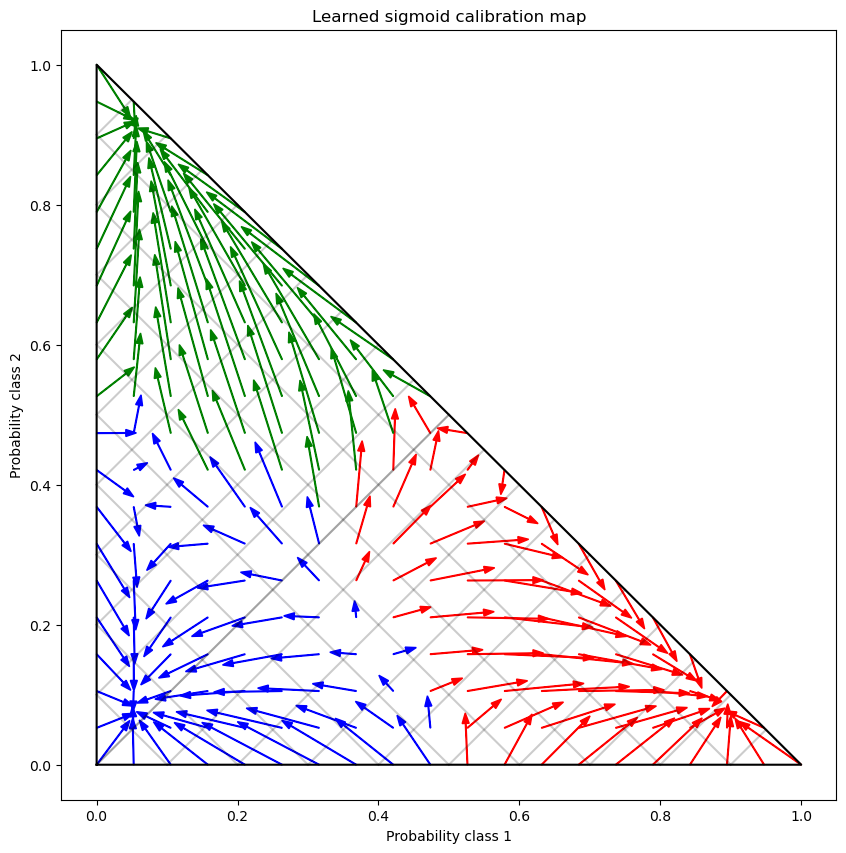

In [6]:
plt.figure(figsize=(10, 10))
# Generate grid of probability values
p1d = np.linspace(0, 1, 20)
p0, p1 = np.meshgrid(p1d, p1d)
p2 = 1 - p0 - p1
p = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p = p[p[:, 2] >= 0]

# Calculate calibrated probabilities using the three class-wise calibrators.
calibrated_classifier = cal_clf.calibrated_classifiers_[0]
prediction = np.vstack(
    [
        calibrator.predict(this_p)
        for calibrator, this_p in zip(calibrated_classifier.calibrators, p.T)
    ]
).T


prediction /= prediction.sum(axis=1)[:, None]

# Display the changes in predicted probabilities caused by the calibrators.
for i in range(prediction.shape[0]):
    plt.arrow(
        p[i, 0],
        p[i, 1],
        prediction[i, 0] - p[i, 0],
        prediction[i, 1] - p[i, 1],
        head_width=1e-2,
        color=colors[np.argmax(p[i])],
    )

# Plot the boundaries of the unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Learned sigmoid calibration map")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()